In [44]:
import os
import string
import time
from collections import defaultdict
from itertools import chain
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 200)

import pymorphy2
from scipy.stats import gmean, hmean
from sklearn.cluster import AgglomerativeClustering, DBSCAN, OPTICS  # noqa
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import ParameterGrid

from hdbscan import HDBSCAN  # noqa

from src.substs_loading import load_substs

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
class Lemmatizer:
    def __init__(self, mode='default'):
        self.mode = mode
        self.morph = pymorphy2.MorphAnalyzer()

    def lemmatize_row_simple(self, probs_row: List[Tuple[float, str]]):
        lemmatizer = lambda x: self.morph.parse(x.strip())[0].normal_form

        total_prob = defaultdict(int)
        for prob, word in probs_row:
            total_prob[lemmatizer(word)] += prob
        norm_coef = sum(prob for word, prob in total_prob.items())
        new_prob_list = sorted([(prob / norm_coef, word) for word, prob in total_prob.items()], reverse=True)
        return new_prob_list

    def lemmatize_row_averaged(self, probs_row: List[Tuple[int, str]]):
        raise NotImplementedError()

    def lemmatize_row(self, probs_row: List[Tuple[int, str]]):
        prepared_row = self.prepare_row(probs_row)
        if self.mode == 'simple':
            return self.lemmatize_row_simple(prepared_row)
        elif self.mode == 'averaged':
            return self.lemmatize_row_averaged(prepared_row)
        elif self.mode == 'default':
            return prepared_row

    def prepare_row(self, probs_row: List[Tuple[int, str]]):
        remove_punc = lambda word: word.translate(str.maketrans('', '', string.punctuation))
        prep_row = [(prob, remove_punc(word)) for prob, word in probs_row]

        split_nwords_substs = lambda row: list(chain(
            *[
                [(prob, spl_word) for spl_word in subst.split()]
                for prob, subst in row
            ]
        ))
        prep_row = split_nwords_substs(prep_row)

        return prep_row

In [46]:
class Vectorizer:
    """
        Take all texts with probs from all documents and vectorize is with some method.
    """

    def __init__(self, vec_mode='count',
                 comb_mode='harm', ood_mode='eps', ood_prob=1e-7, top_k=150,
                 feature_select_mode=None, keep_imp_proc=0.5, debug=False,
                 **vectorizer_conf):
        """
            args:
                vec_mode:           type of Vectorizer from sklearn (or mb custom)
                with_probs:         multiply vectorizer numbers by prob. of subst
                comb_mode:          mode of combining probs from files
                ood_prob:           probability for words appearing only in one file
                vectorizer_conf:    settings for vectorizer

        """
        self.important_words = None
        if vec_mode == 'count':
            self.vectorizer = CountVectorizer(
                preprocessor=lambda x: x,
                **vectorizer_conf
            )
        elif vec_mode == 'tfidf':
            self.vectorizer = TfidfVectorizer(
                preprocessor=lambda x: x,
                **vectorizer_conf
            )
        self.comb_mode = comb_mode
        self.ood_mode = ood_mode
        self.ood_prob = ood_prob
        self.top_k = top_k
        self.comb_mapping = {
            'geom': gmean,
            'harm': hmean,
            'mean': np.mean,
            'prod': np.prod,
        }
        self.feature_selection_mode = feature_select_mode
        self.keep_important_proc = keep_imp_proc
        self.debug = debug

    def comb_prob(self, probs: Tuple[float]):
        try:
            res_prob = self.comb_mapping[self.comb_mode](probs)
        except Exception:
            print(probs)
            raise
        return res_prob

    def unite_n_rows(self, probs_rows_df: Tuple[List[Tuple[float, str]]]):
        """
            Unite n rows from different files into one row and leaves only top_k substs.
        """
        probs_rows = tuple(probs_rows_df)
        XML_DICT_SIZE = 2.5 * 10 ** 6
        if self.ood_mode == 'eps':
            ood_probs = [self.ood_prob for row in probs_rows]
        elif self.ood_mode == 'res_mean':
            ood_probs = [(1 - sum(prob for prob, word in row)) / (XML_DICT_SIZE - len(row)) for row in
                         probs_rows]  # probs if subst from other file not presented

        all_substs = set(word for prob, word in chain(*probs_rows) if word != '')
        file_word_probs = [
            {file_row_word: file_row_prob for file_row_prob, file_row_word in p_s_row}
            for p_s_row in probs_rows
        ]
        substs_probs = {
            word: tuple(file_probs.get(word, ood_probs[ind]) for ind, file_probs in enumerate(file_word_probs))
            for word in all_substs
        }
        new_probs_substs = sorted([(self.comb_prob(w_probs), word) for word, w_probs in substs_probs.items()],
                                  reverse=True)
        return new_probs_substs[:self.top_k]

    def unite_words_dfs(self, splitted_word_dfs: List[List[pd.DataFrame]]) -> List[pd.DataFrame]:
        """
        Structure of input data:
            List by files
                List by unique word
                    Df with substs
        """
        words_substs_probs = []
        for files_word_dfs in zip(*splitted_word_dfs):
            # Merge many dfs into one, to perform apply later
            res: pd.DataFrame = files_word_dfs[0]
            for ind, df in enumerate(files_word_dfs[1:]):
                res = pd.merge(res, df, left_index=True, right_index=True, suffixes=(None, f'{ind + 1}'))
            res = res.drop(columns=list(res.filter(regex='word\d+')))

            # Merging probs from different files
            new_probs = res.filter(regex='probs').apply(self.unite_n_rows, axis=1)
            res = res.drop(columns=list(res.filter(regex='substs_probs')))
            res['substs_probs'] = new_probs

            words_substs_probs.append(res)

        return words_substs_probs

    def vectorize_word_df(self, word_df: pd.DataFrame) -> np.ndarray:
        if self.important_words is not None:
            text_from_row = lambda row: ' '.join([word for prob, word in row if word in self.important_words])
        else:
            text_from_row = lambda row: ' '.join([word for prob, word in row])
        df_texts = list(word_df.substs_probs.apply(text_from_row))
        vectorized_texts = self.vectorizer.fit_transform(df_texts).toarray()
        return vectorized_texts

    def feature_selection(self, word_dfs_lists: List[pd.DataFrame]):
        """
            Check chi2/mutual_inf for every subst in dataset and keeps set of some percent of most important words
        """
        print("FEATURE SELECTION makes brrrr")
        
        all_words_df = pd.concat(word_dfs_lists)
        all_words_vectorized = self.vectorize_word_df(all_words_df)
        all_words_labels = np.concatenate([np.repeat(ind, df.shape[0]) for ind, df in enumerate(word_dfs_lists)])
        if self.debug:
            for i in range(3):
                print(f"Text {i}:", all_words_vectorized[i], f"Total words: {sum(all_words_vectorized[i])}")
                print(f"Label{all_words_labels[i]}")
        
        ind2word = {ind: word for word, ind in self.vectorizer.vocabulary_.items()}
        num_remove = int(len(ind2word) * (1 - self.keep_important_proc))
        if self.feature_selection_mode == 'chi2':
            feature_imp = chi2(all_words_vectorized, all_words_labels)[0]
        else:
            feature_imp = mutual_info_classif(all_words_vectorized, all_words_labels, discrete_features=True)
        imp_order = np.argsort(feature_imp)
        if self.debug:
            print("20 most useless words: ")
            not_imp_20 = {
                'word': [ind2word[ind] for ind in imp_order[:20]], 
                'importance_score': [feature_imp[ind]for ind in imp_order[:20]] 
            }
            print(pd.DataFrame(not_imp_20))
            print('20 most important words')
            imp_20 = {
                'word': [ind2word[ind] for ind in imp_order[-20:]], 
                'importance_score': [feature_imp[ind]for ind in imp_order[-20:]] 
            }
            print(pd.DataFrame(imp_20))

            
        self.important_words = {ind2word[ind] for ind in imp_order[num_remove:]}
        print(len(self.important_words))
        print("SELECTION FINISHED")
    
    def transform(self, splitted_texts: List[List[pd.DataFrame]]) -> List[np.ndarray]:
        print("VECTORIZER TRANSFORM STARTED: ")
        st = time.time()
        self.words_dfs_list = self.unite_words_dfs(splitted_texts)
        if self.feature_selection_mode is not None:
            self.feature_selection(self.words_dfs_list)
        words_vec_texts = [
            self.vectorize_word_df(df) for df in self.words_dfs_list
        ]
        print(f"Vectorizing finished in {time.time() - st} sec.")
        return words_vec_texts

In [47]:
class Clusterizer:
    def __init__(self, clust_mode='agg', cluster_range: Tuple[int, int] = (2, 6),
                 **clusterizer_config):
        self.clustering_mapping = {
            'agg': AgglomerativeClustering,
            'dbscan': DBSCAN,
            'hdbscan': HDBSCAN,
            'optics': OPTICS,
        }
        self.clusterizer = self.clustering_mapping[clust_mode](**clusterizer_config)
        self.cluster_range = range(*cluster_range)

    def _compute_all_labels(self, vectorized_texts: List[np.ndarray]):
        """
        Compute labels for all n_cluster in cluster_range
        """
        print("COMPUTING LABELS STARTED")
        self.all_pred_labels: List[Dict[int, np.ndarray]] = []
        for vec_texts in vectorized_texts:
            word_pred_labels = dict()
            for num_clust in self.cluster_range:
                self.clusterizer.set_params(n_clusters=num_clust)
                pred_labels = self.clusterizer.fit_predict(vec_texts)
                word_pred_labels[num_clust] = pred_labels
            self.all_pred_labels.append(word_pred_labels)
        print("COMPUTING LABELS FINISHING")

    def compute_metrics(self, mode='all', vectorized_texts: List[np.ndarray]=None, true_labels: List[np.ndarray]=None):
        self._compute_all_labels(vectorized_texts)
        if mode in ('silh', 'all'):
            self.all_slih_results = [
                {
                    nc: silhouette_score(vec_word_text, pred_lab)
                    for nc, pred_lab in self.all_pred_labels[ind_w].items()
                }
                for ind_w, vec_word_text in enumerate(vectorized_texts)
            ]
        if mode in ('ari', 'fncari', 'all'):
            self.all_ari_results = [
                {
                    nc: adjusted_rand_score(true_labels[ind_w], pred_lab)
                    for nc, pred_lab in all_word_pred_labels.items()
                }
                for ind_w, all_word_pred_labels in enumerate(self.all_pred_labels)
            ]

    def silhouette_metric(self):
        max_silh_clust = [
            max(word_silh_result.items(), key=lambda x: x[1])[0] for word_silh_result in self.all_slih_results
        ]
        max_silh_results = [
            (nc, self.all_ari_results[w_ind][nc]) for w_ind, nc in enumerate(max_silh_clust)
        ]
#         print(max_silh_results)
        return max_silh_results

    def ari_metric(self):
        max_ari_results = [
            max(word_ari_result.items(), key=lambda x: x[1]) for word_ari_result in self.all_ari_results
        ]
        return max_ari_results

    def fixed_nc_ari_metric(self):
        fnc_ari_results = {
            nc: np.mean([all_word_ari[nc] for w_ind, all_word_ari in enumerate(self.all_ari_results)])
            for nc in self.cluster_range
        }
        return fnc_ari_results

    def get_best_metrics(self):
#         print("best metrics")
        return {
            'silh': np.mean([silh for nc, silh in self.silhouette_metric()]),
            'ari': np.mean([ari for nc, ari in self.ari_metric()]),
            'fixed_nc_ari': max(self.fixed_nc_ari_metric().items(), key=lambda x: x[1])
        }

    def clusterize(self):
        silh_res = self.silhouette_metric()
        pred_labels = [
            self.all_pred_labels[w_ind][nc] for w_ind, (silh, nc) in enumerate(silh_res)
        ]
        return pred_labels

In [48]:
class WSIPipeline:
    morph = pymorphy2.MorphAnalyzer()

    def __init__(self, cluster_range: Tuple[int, int] = (2, 6)):
        self.lemmatizer: Optional[Lemmatizer] = None
        self.vectorizer: Optional[Vectorizer] = None
        self.clusterizer: Optional[Clusterizer] = None

    def load_files(self, data_directory: str, files: List[str]):
        self.files_dfs: List[pd.DataFrame] = []
        print(data_directory, files)
        for filename in files:
            full_path = os.path.realpath(data_directory + '/' + filename)
            if filename.endswith('.pkl'):
                df = pd.read_pickle(full_path)
            else:
                df = load_substs(full_path)
            tmp_df = df.filter(['word', 'substs_probs', 'gold_sense_id'])
            self.files_dfs.append(tmp_df)
            
        self.ind2word = dict(enumerate(self.files_dfs[0].word.unique()))
        self.word2ind = {word: ind for ind, word in self.ind2word.items()}
        
        self.true_labels = [
            self.files_dfs[0][self.files_dfs[0].word == uniq_w].gold_sense_id.to_numpy()
            for uniq_w in self.word2ind
        ]

    def lemmatize_probs_dfs(self, mode='default'):
        """
            Lemmatize all probs from dataset df
        """
        st = time.time()
        self.lemmatizer = Lemmatizer(mode=mode)
        tmp_files_dfs = []
        for ind, df in enumerate(self.files_dfs):
            tmp_df = df.copy()
            tmp_df.substs_probs = tmp_df.substs_probs.apply(self.lemmatizer.lemmatize_row)
            tmp_files_dfs.append(tmp_df)

        self.files_dfs = tmp_files_dfs
        print(f"Lemmatize finished in {time.time() - st} sec.")

    def vectorize_probs(self, **vectorizer_params):
        
        self.files_words_dfs = [
            [df[df.word == uniq_w] for uniq_w in self.word2ind]
            for df in self.files_dfs
        ]
        self.vectorizer = Vectorizer(**vectorizer_params)
        self.vectorized_words_substs: List[np.ndarray] = self.vectorizer.transform(self.files_words_dfs)
#         print(self.vectorizer.words_dfs_list[0])

    def clusterize(self, **clustering_config):
        self.clusterizer = Clusterizer(**clustering_config)
        self.clusterizer.compute_metrics(
            vectorized_texts=self.vectorized_words_substs,
            true_labels=self.true_labels
        )
        return self.clusterizer.clusterize()

    def get_cluster_metrics(self, **clustering_config):
        self.clusterizer = Clusterizer(**clustering_config)
        self.clusterizer.compute_metrics(
            vectorized_texts=self.vectorized_words_substs,
            true_labels=self.true_labels
        )
        return self.clusterizer.get_best_metrics()

In [49]:
def grid_search(wsi_conf, lemma_conf, vector_conf, cluster_conf, searching_params):
    results = []
    seaborn_res = {
            'params': [],
            'metric': [],
            'value': []
    }
    wsi_pipeline = WSIPipeline()
    
    
    for wc in ParameterGrid(wsi_conf):
        
        wsi_pipeline.load_files(data_directory=wc['dir'], files=wc['files'])
        for lc in ParameterGrid(lemma_conf):
            
            wsi_pipeline.lemmatize_probs_dfs(**lc)
            
            for vc in ParameterGrid(vector_conf):
                
                wsi_pipeline.vectorize_probs(**vc)
                
                for cc in ParameterGrid(cluster_conf):
                    metrics = wsi_pipeline.get_cluster_metrics(**cc)
                    all_params = wc | lc | vc | cc
                    search_params_values = tuple(all_params[param] for param in searching_params)
                    results.append((search_params_values, metrics))
                    for met, val in metrics.items():
                        seaborn_res['params'].append(search_params_values)
                        seaborn_res['metric'].append(met)
                        seaborn_res['value'].append(val[1] if met=='fixed_nc_ari' else val)
                    print('-' * 20)
                    
    return results, seaborn_res  # TODO: namedtuple

In [50]:
default_wsi_conf = {
    'dir': [r'./subst_train/active_subst'],
    'files': [
        (r"mmm(T)-lemmatized-simple.pkl", r"T(mmm)-lemmatized-simple.pkl")
#         (r'm(T).npz', )
    ],
}
default_lemma_conf = {
    'mode': ['default'],
}
default_vec_conf = {
    'vec_mode': ['count'],
#     'comb_mode':['geom', 'harm', 'mean', 'prod'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150],
    'ood_prob': [1e-7],
    'min_df': [3],
}
default_clustering_conf = {
    'clust_mode': ['agg'],  # type of clustering model (agg, dbscan, optics)
    'affinity': ['cosine'],  # affinity for clustering model
    'linkage': ['average'],  # linkage for agg model
    'memory': ['./cache'],  # memory for agg model
}

Сначала посмотрим на результаты объединенных подстановок против одинарных.

In [51]:
comp_substs_wsi_conf = {
    'dir': [r'./subst_train/active_subst'],
    'files': [
        (r"mmm(T)-lemmatized-simple.pkl", r"T(mmm)-lemmatized-simple.pkl"),
        (r"mm(T)-lemmatized-simple.pkl", r"T(mm)-lemmatized-simple.pkl"),
        (r"m(T)-lemmatized-simple.pkl", r"T(m)-lemmatized-simple.pkl"),
    ],
}

In [52]:
comp_substs_metrics = grid_search(
    comp_substs_wsi_conf, 
    default_lemma_conf, 
    default_vec_conf, 
    default_clustering_conf,
    searching_params = ['files']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 3.7517974376678467 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.753484725952148 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
./subst_train/active_subst ('mm(T)-lemmatized-simple.pkl', 'T(mm)-lemmatized-simple.pkl')
Lemmatize finished in 5.479820013046265 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 16.943246841430664 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
./subst_train/active_subst ('m(T)-lemmatized-simple.pkl', 'T(m)-lemmatized-simple.pkl')
Lemmatize finished in 3.313563346862793 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 11.338050127029419 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------


In [53]:
comp_substs_metrics[0]

[((('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl'),),
  {'silh': 0.6183834777682594,
   'ari': 0.6876114674925625,
   'fixed_nc_ari': (3, 0.6056127975721497)}),
 ((('mm(T)-lemmatized-simple.pkl', 'T(mm)-lemmatized-simple.pkl'),),
  {'silh': 0.6144039699919699,
   'ari': 0.650585335516538,
   'fixed_nc_ari': (3, 0.5893278769179705)}),
 ((('m(T)-lemmatized-simple.pkl', 'T(m)-lemmatized-simple.pkl'),),
  {'silh': 0.4445680697913124,
   'ari': 0.5352731787538815,
   'fixed_nc_ari': (5, 0.3815642444728511)})]

In [54]:
comp_substs_df = pd.DataFrame(
    comp_substs_metrics[1]
)
comp_substs_df

,params,metric,value
0,"((mmm(T)-lemmatized-simple.pkl, T(mmm)-lemmatized-simple.pkl),)",silh,0.618383
1,"((mmm(T)-lemmatized-simple.pkl, T(mmm)-lemmatized-simple.pkl),)",ari,0.687611
2,"((mmm(T)-lemmatized-simple.pkl, T(mmm)-lemmatized-simple.pkl),)",fixed_nc_ari,0.605613
3,"((mm(T)-lemmatized-simple.pkl, T(mm)-lemmatized-simple.pkl),)",silh,0.614404
4,"((mm(T)-lemmatized-simple.pkl, T(mm)-lemmatized-simple.pkl),)",ari,0.650585
5,"((mm(T)-lemmatized-simple.pkl, T(mm)-lemmatized-simple.pkl),)",fixed_nc_ari,0.589328
6,"((m(T)-lemmatized-simple.pkl, T(m)-lemmatized-simple.pkl),)",silh,0.444568
7,"((m(T)-lemmatized-simple.pkl, T(m)-lemmatized-simple.pkl),)",ari,0.535273
8,"((m(T)-lemmatized-simple.pkl, T(m)-lemmatized-simple.pkl),)",fixed_nc_ari,0.381564


In [55]:
comp_substs_df.params = comp_substs_df.params.apply(lambda x: tuple(map(lambda y: y[0].split('-')[0]+'+'+y[1].split('-')[0], x)))

[Text(0.5, 0, 'substs')]

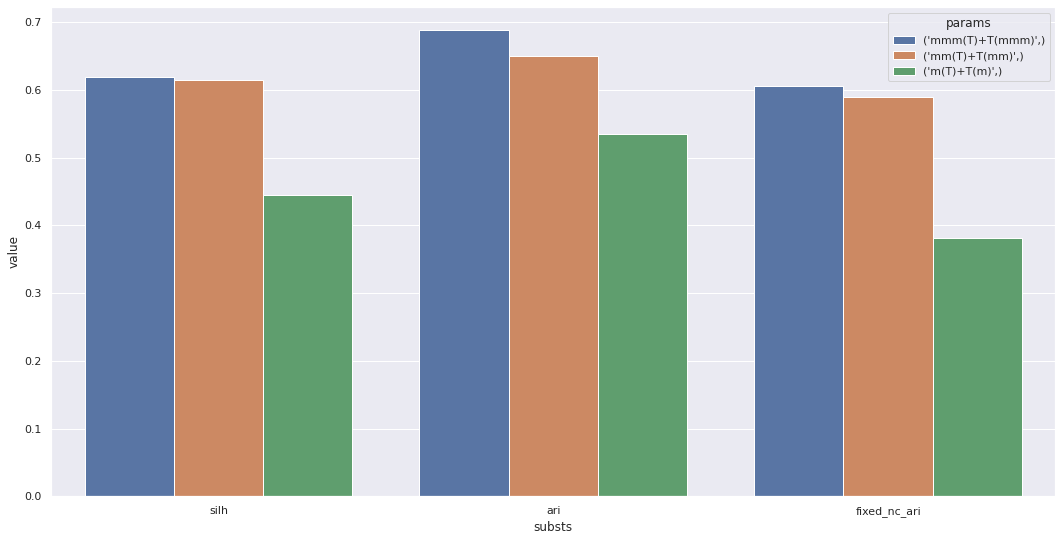

In [56]:
sns.set(rc={'figure.figsize':(18,9)})
sns.barplot(data=comp_substs_df, x='metric', y='value', hue='params').set(xlabel='substs')

Ну кажется тройные подстановки работают лучше всего, теперь попробуем для них остальные параметры.

### offtopic 
Вероятности в файлах с подстановками не нормализованы, это норм.

**Проблема**: Что делаем со подстановками из нескольких слов?<br>
**Решение**: делим на несколько слов<br>
**Проблема**: при лемматизации хочется складывать вероятности одинаковых слов, в итоге получается больше 1 и не можем сделать вероятность слова вне строки подстановок через деление остатка на размер словаря.<br>
**Решение**: пусть получается, потом нормализуем, а для слов вне словаря тогда вероятность задаём вручную через EPS, а не через деление остатка на размер словаря.<br>

Попробуем теперь покрутить **top_k** и **comb_mode**

In [57]:
geom_harm_topk_vec_conf = {
    'vec_mode': ['count'],
#     'comb_mode':['geom', 'harm', 'mean', 'prod'],
    'comb_mode': ['geom', 'harm'],
    'ood_mode': ['eps'],
    'top_k': [150, 125, 100, 75, 50, 25],
    'ood_prob': [1e-7],
    'min_df': [3],
}

In [58]:
geom_harm_topk_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    geom_harm_topk_vec_conf, 
    default_clustering_conf,
    searching_params = ['comb_mode', 'top_k']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 3.4977846145629883 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 16.325066566467285 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 16.86753487586975 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 15.305169105529785 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 15.405652284622192 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 14.967082500457764 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 13.26952600479126 sec.
COMPUTING LABELS STARTED


[Text(0.5, 0, 'comb_mode+top_k')]

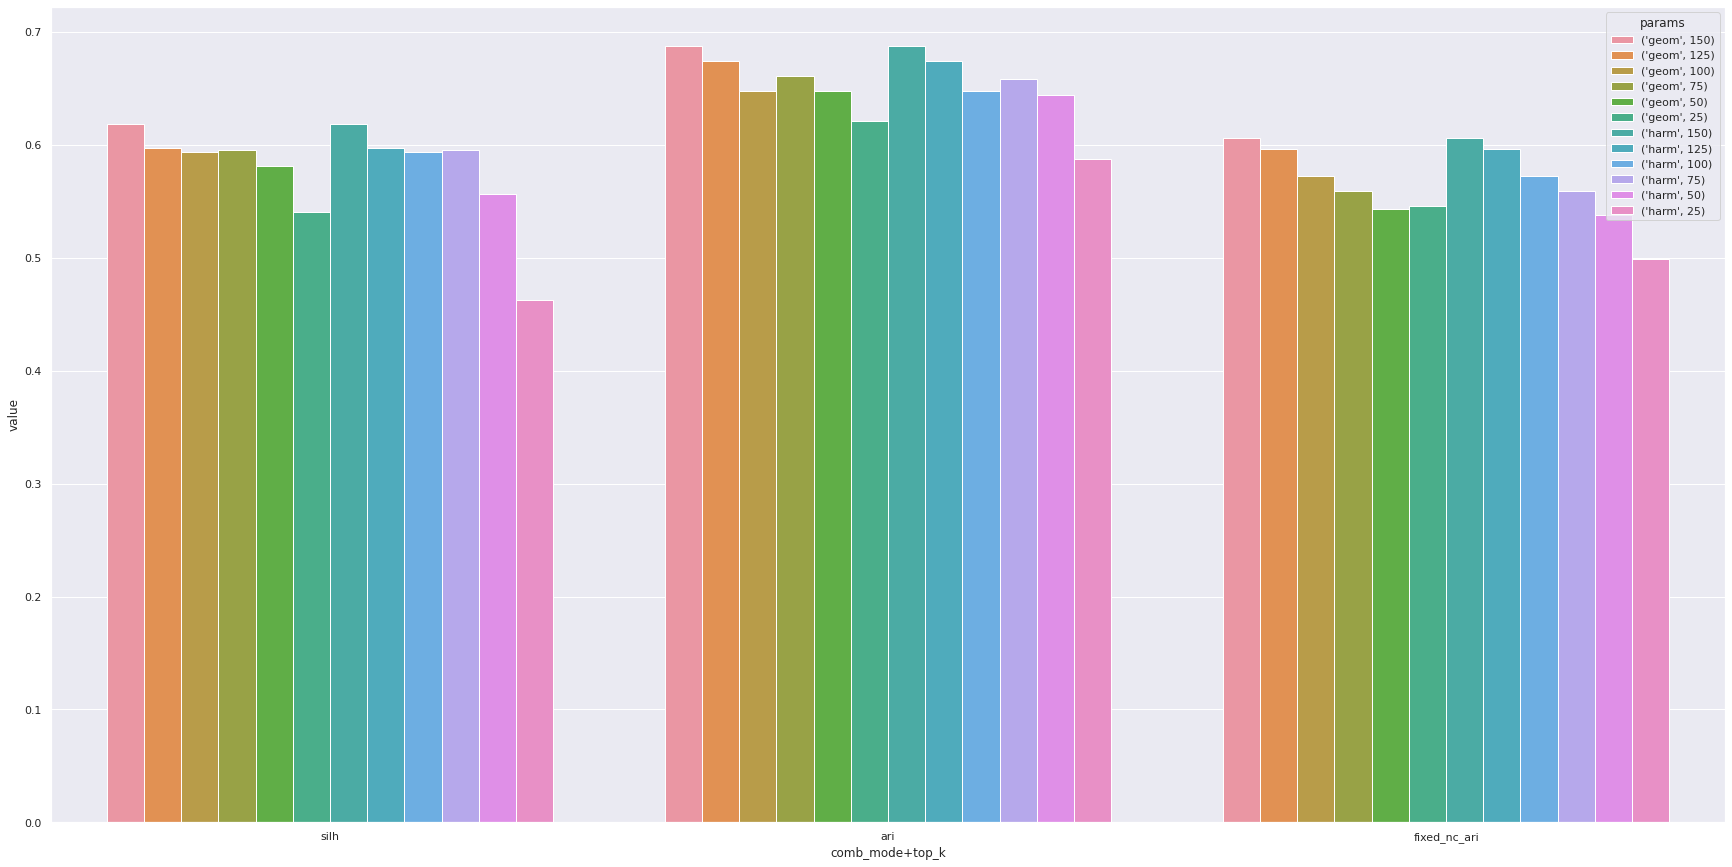

In [92]:
sns.set(rc={'figure.figsize':(30,15)})
sns.barplot(data=pd.DataFrame(geom_harm_topk_metrics[1]), x='metric', y='value', hue='params').set(xlabel='comb_mode+top_k')

Выводы можно сделать следующие, лемматизация хорошо работает, поэтому при больших значениях топ_к различия между средним геометрическим и средним гармоническим почти не будет. По мере уменьшения top_k разница будет появляться, но в целом тоже не большая

Ещё примечаение, среднее гармоническое считается в 2 раза дольше и работает хуже)) в целом всё понятно.

Теперь посмотрим среднее арифметическое и простое произведение.

In [60]:
mean_prod_topk_vec_conf = {
    'vec_mode': ['count'],
#     'comb_mode':['geom', 'harm', 'mean', 'prod'],
    'comb_mode': ['mean', 'prod'],
    'ood_mode': ['eps'],
    'top_k': [150, 125, 100, 75, 50, 25],
    'ood_prob': [1e-7],
    'min_df': [3],
}

In [61]:
mean_prod_topk_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    mean_prod_topk_vec_conf, 
    default_clustering_conf,
    searching_params = ['comb_mode', 'top_k']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 3.2209720611572266 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 11.667582035064697 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 11.83443808555603 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 10.847305297851562 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 11.278366327285767 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 10.154009342193604 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 10.872634887695312 sec.
COMPUTING LABELS STARTED

[Text(0.5, 0, 'comb_mode+top_k')]

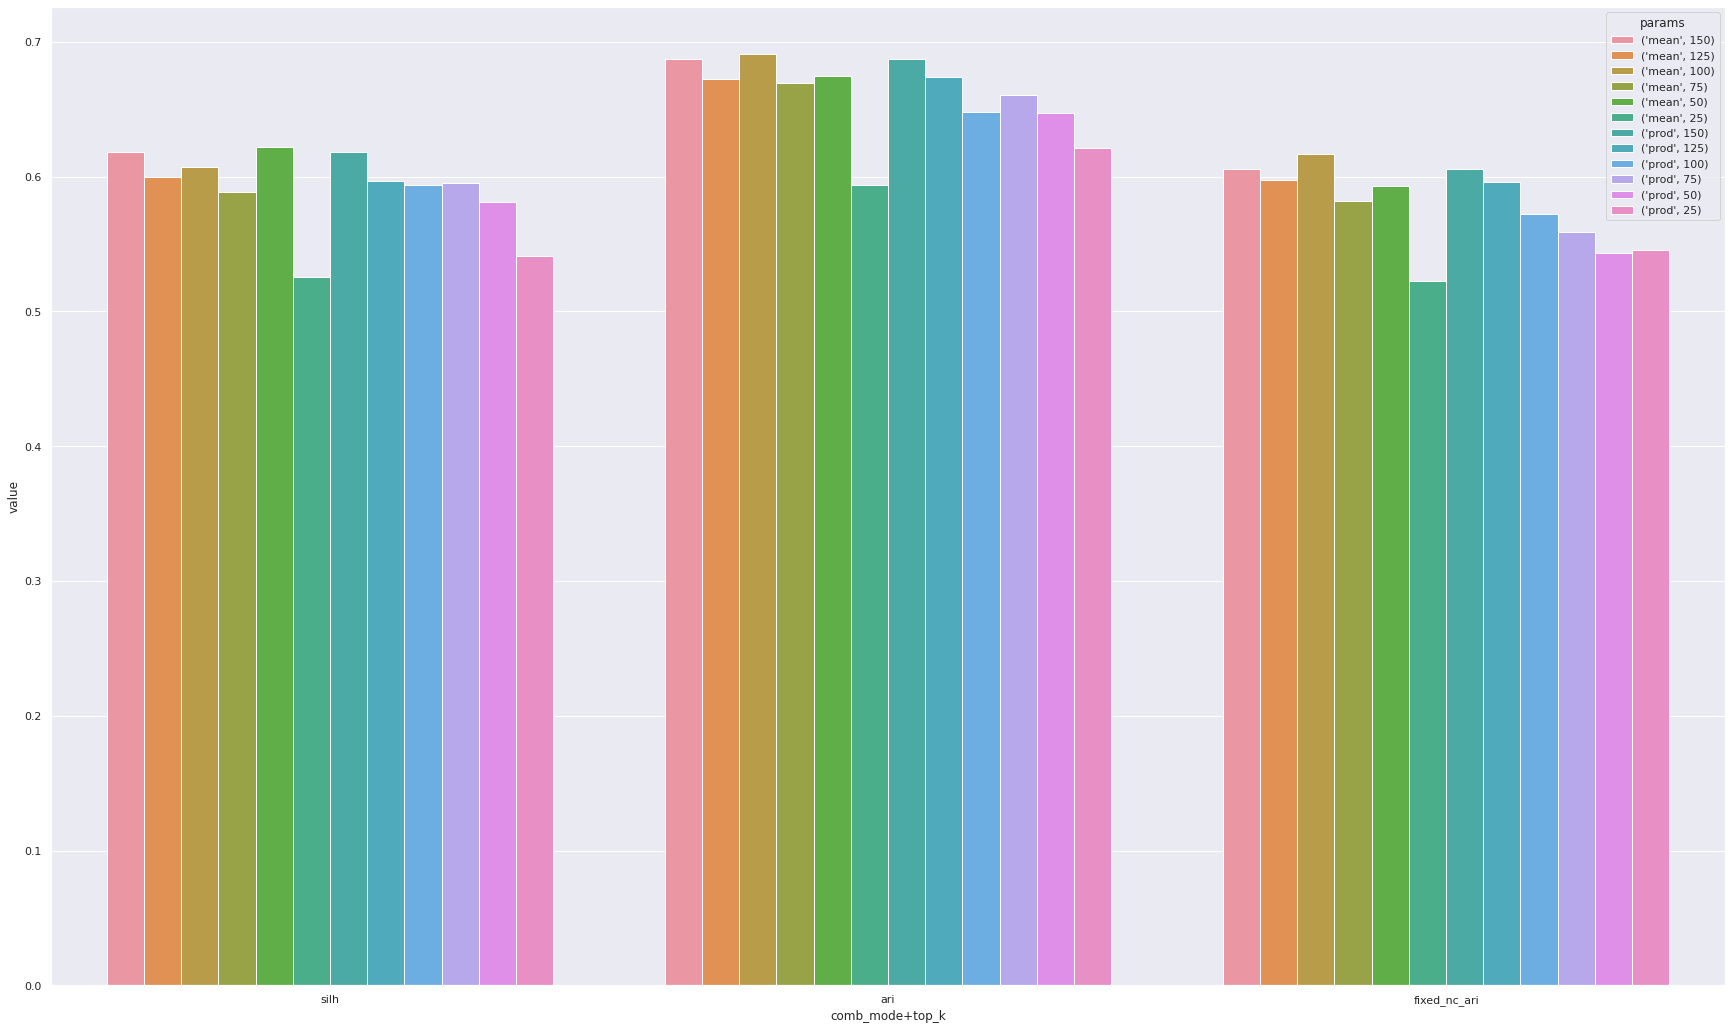

In [94]:
sns.set(rc={'figure.figsize':(30,18)})
sns.barplot(data=pd.DataFrame(mean_prod_topk_metrics[1]), x='metric', y='value', hue='params').set(xlabel='comb_mode+top_k')

In [63]:
all4_top100_vec_conf = {
    'vec_mode': ['count'],
    'top_k': [125, 100, 75],
    'comb_mode':['geom', 'harm', 'mean', 'prod'],
#     'comb_mode': ['mean', 'prod'],
    'ood_mode': ['eps'],
    
    'ood_prob': [1e-7],
    'min_df': [3],
}

In [64]:
all4_top100_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    all4_top100_vec_conf, 
    default_clustering_conf,
    searching_params = ['top_k', 'comb_mode']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 3.5307602882385254 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 14.211681127548218 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 13.407022476196289 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.999826908111572 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 24.6891827583313 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 25.485001802444458 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 25.36639428138733 sec.
COMPUTING LABELS STARTED
C

[Text(0.5, 0, 'comb_mode+top_k')]

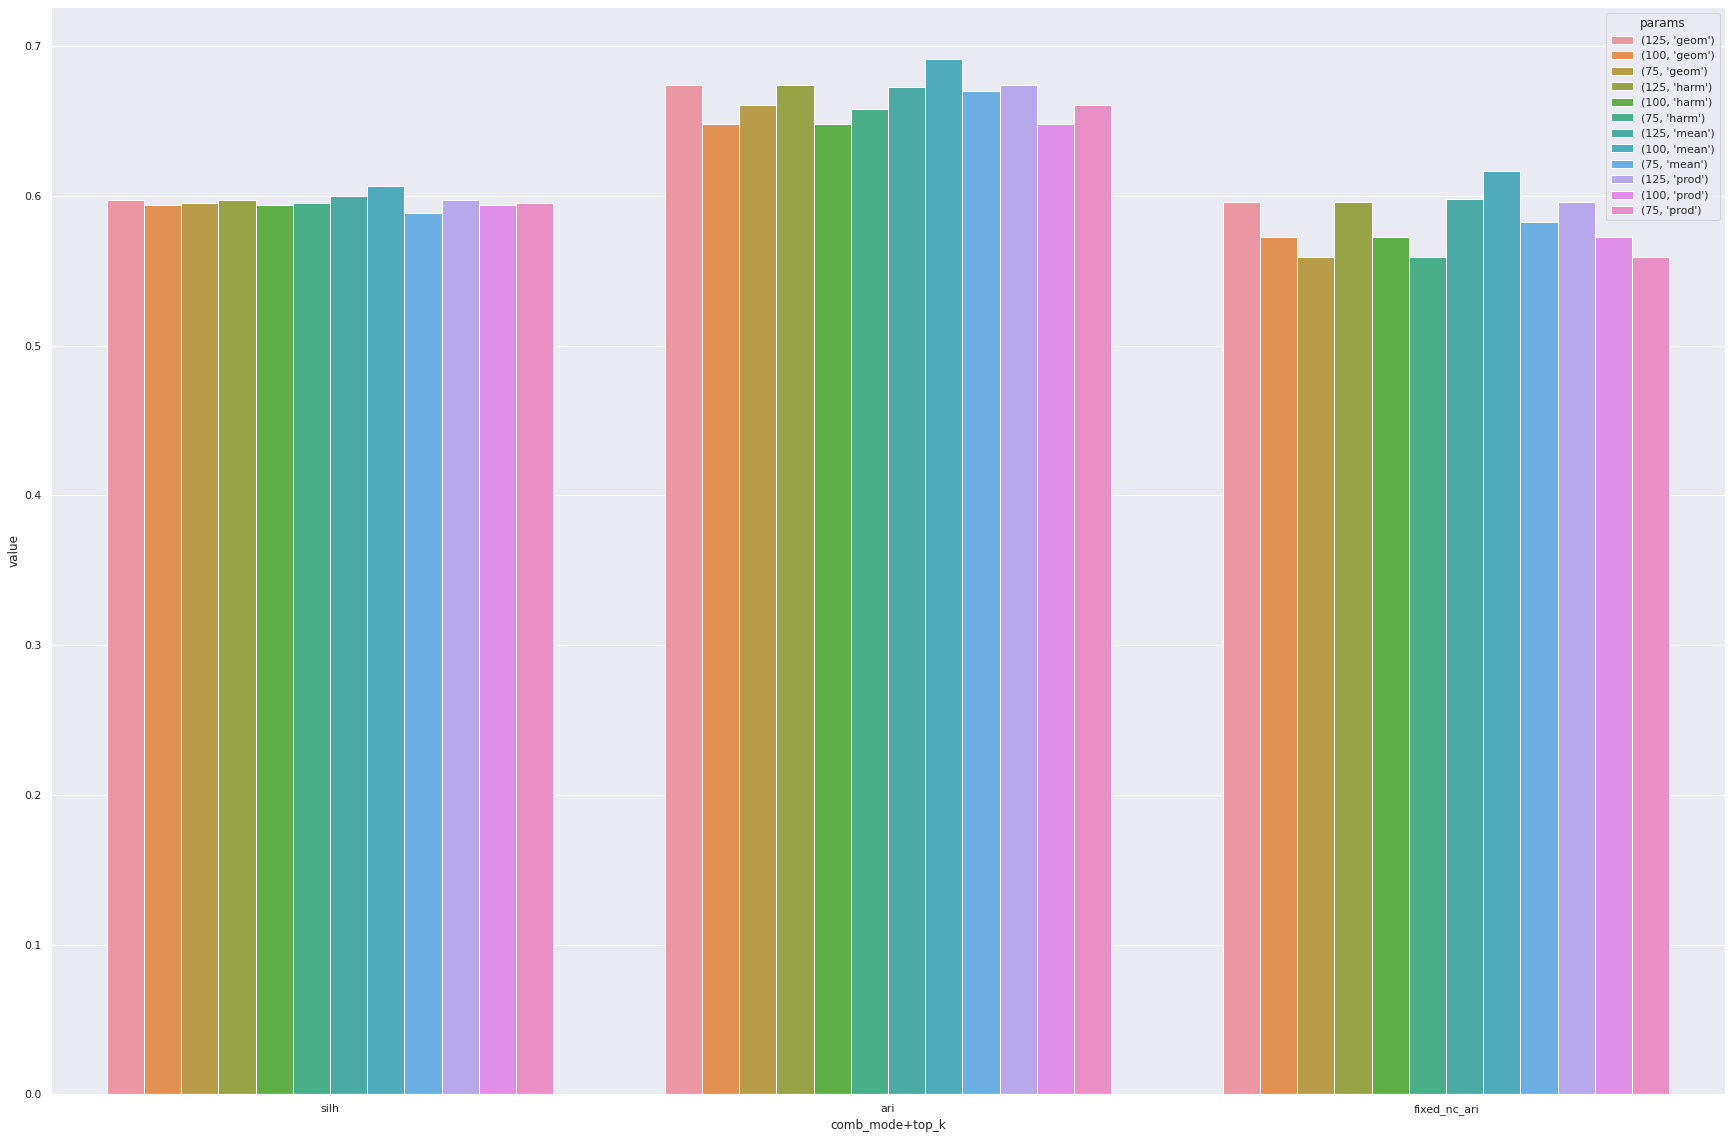

In [96]:
sns.set(rc={'figure.figsize':(30,20)})

right_df = pd.DataFrame(all4_top100_metrics[1])#.sort_values(['value']).reset_index(drop=False)
sns.barplot(data=right_df, x='metric', y='value', hue='params').set(xlabel='comb_mode+top_k')

Что-то метод объединения влияет не сильно, а лучшим вообще оказалось среднее арифметическое, это необычно.

In [66]:
alot_substs_wsi_conf = {
    'dir': [r'./subst_train/active_subst'],
    'files': [
        (r"mmm(T)-lemmatized-simple.pkl", r"T(mmm)-lemmatized-simple.pkl",),
        (r"mmm(T)-lemmatized-simple.pkl", r"T(mmm)-lemmatized-simple.pkl", r"mm(T)-lemmatized-simple.pkl", r"T(mm)-lemmatized-simple.pkl"),
        (r"mmm(T)-lemmatized-simple.pkl", r"T(mmm)-lemmatized-simple.pkl", r"mm(T)-lemmatized-simple.pkl", r"T(mm)-lemmatized-simple.pkl",r"m(T)-lemmatized-simple.pkl", r"T(m)-lemmatized-simple.pkl"),
    ],
}
alot_substs_vec_conf = {
    'vec_mode': ['count'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150, 100],
    'ood_prob': [1e-7],
    'min_df': [3],
}

In [67]:
alot_substs_metrics = grid_search(
    alot_substs_wsi_conf, 
    default_lemma_conf, 
    alot_substs_vec_conf, 
    default_clustering_conf,
    searching_params = ['files', 'top_k']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 3.0694642066955566 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 10.6791353225708 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 10.654478549957275 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl', 'mm(T)-lemmatized-simple.pkl', 'T(mm)-lemmatized-simple.pkl')
Lemmatize finished in 6.812265634536743 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 19.82493758201599 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 19.726722240447998 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl'

In [71]:
short_names = lambda x: '+'.join([name[:-4].split('-')[0] for name in x[0]]) + '\n' + str(x[1])

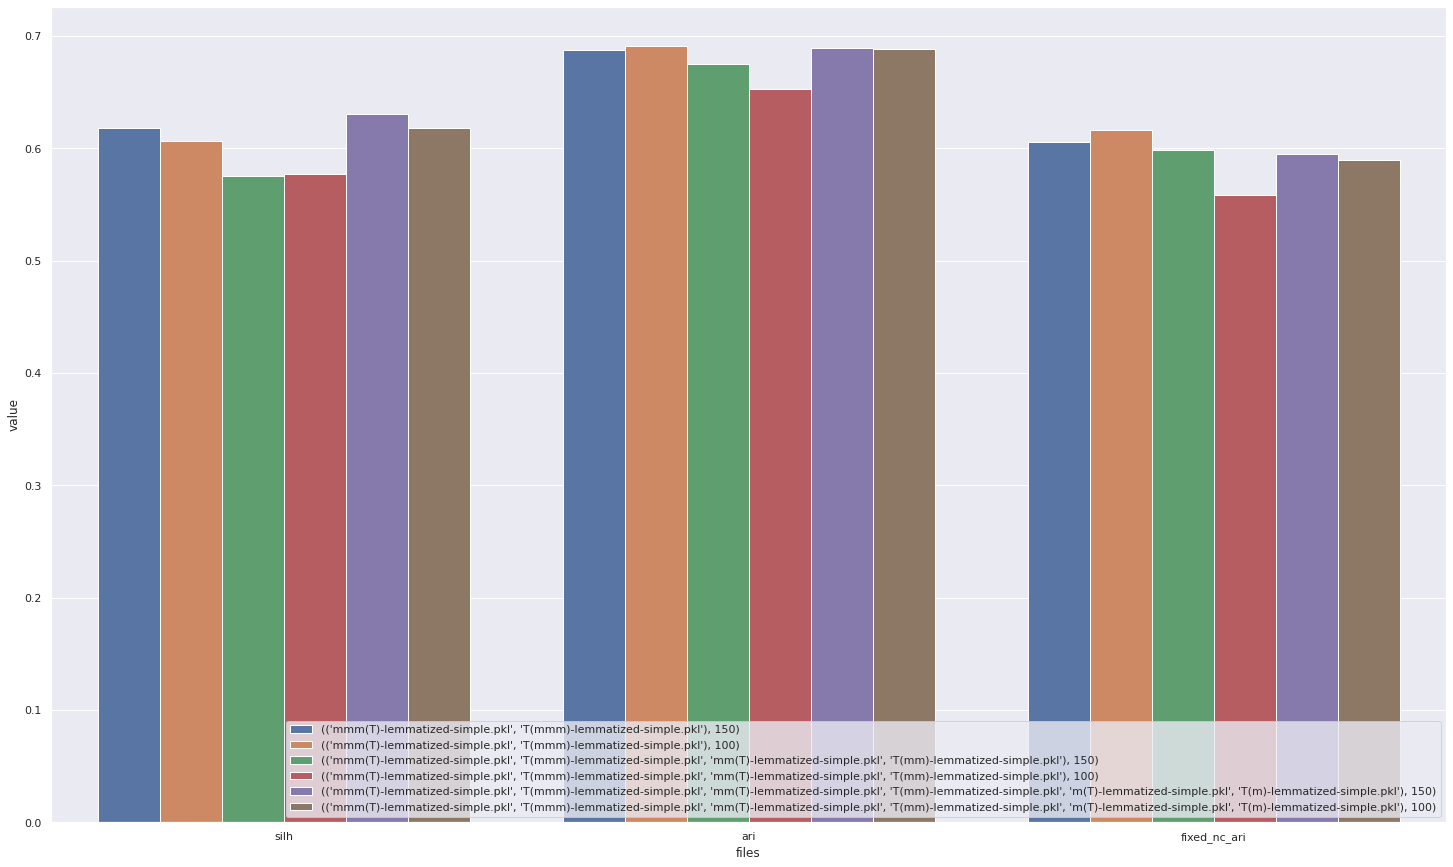

In [107]:
sns.set(rc={'figure.figsize':(25,15)})


alot_substs_df = pd.DataFrame(alot_substs_metrics[1])#.sort_values(['value']).reset_index(drop=False)
tmp = sns.barplot(data=alot_substs_df, x='metric', y='value', hue='params').set(xlabel='files')
plt.legend(loc='lower right')

Проверяем feature_importance

In [74]:
feat_imp_wsi_conf = {
    'dir': [r'./subst_train/active_subst'],
    'files': [
        (r"mmm(T)-lemmatized-simple.pkl", r"T(mmm)-lemmatized-simple.pkl",),
    ],
}
feat_imp_vec_conf = {
    'vec_mode': ['count'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150],
    'ood_prob': [1e-7],
    'min_df': [3],
    'feature_select_mode': ['chi2'],
    'keep_imp_proc': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
}

In [75]:
feat_imp_chi2_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    feat_imp_vec_conf, 
    default_clustering_conf,
    searching_params = ['feature_select_mode', 'keep_imp_proc']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 4.571423530578613 sec.
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
1589
SELECTION FINISHED
Vectorizing finished in 43.39384913444519 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
3177
SELECTION FINISHED
Vectorizing finished in 43.6914484500885 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
4765
SELECTION FINISHED
Vectorizing finished in 46.60437631607056 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
7941
SELECTION FINISHED
Vectorizing finished in 45.65815734863281 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SELEC

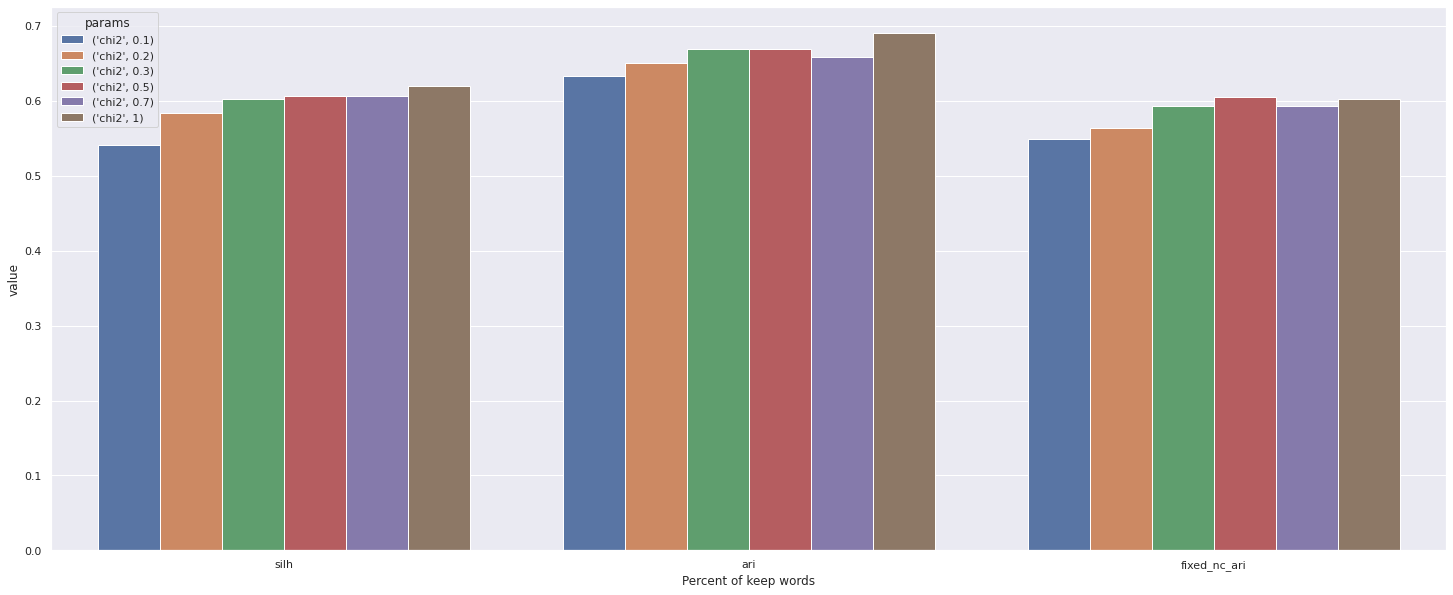

In [108]:
sns.set(rc={'figure.figsize':(25,10)})

feat_chi2_df = pd.DataFrame(feat_imp_chi2_metrics[1])#.sort_values(['value']).reset_index(drop=False)
tmp = sns.barplot(data=feat_chi2_df, x='metric', y='value', hue='params').set(xlabel='Percent of keep words')


Посмотрим, топ 20 самых бесползных слов и топ 20 самых полезных

In [77]:
feat_imp_check_wsi_conf = {
    'dir': [r'./subst_train/active_subst'],
    'files': [
        (r"mmm(T)-lemmatized-simple.pkl", r"T(mmm)-lemmatized-simple.pkl",),
    ],
}
feat_imp_check_vec_conf = {
    'vec_mode': ['count'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150],
    'ood_prob': [1e-7],
    'min_df': [3],
    'feature_select_mode': ['chi2'],
    'keep_imp_proc': [1,],
    'debug': [True]
}

In [78]:
feat_imp_check_chi2_metrics = grid_search(
    feat_imp_check_wsi_conf, 
    default_lemma_conf, 
    feat_imp_check_vec_conf, 
    default_clustering_conf,
    searching_params = ['feature_select_mode', 'keep_imp_proc']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 4.551175594329834 sec.
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
Text 0: [0 0 0 ... 0 0 0] Total words: 144
Label0
Text 1: [0 0 0 ... 0 0 0] Total words: 145
Label0
Text 2: [0 0 0 ... 0 0 0] Total words: 144
Label0
20 most useless words: 
            word  importance_score
0          брать         17.325648
1         оправа         18.722850
2        вызвать         18.934630
3       очевидец         19.057607
4        поэтому         19.314036
5      проектный         19.419337
6    прессслужба         19.496442
7         кругом         19.650588
8       десятина         19.714219
9   прошлогодний         19.746985
10       подмена         19.841574
11        менять         19.951794
12   поддержание         19.959984
13       ситочка         20.057366
14        нагрев         20.095716
15    передавать         20.181388
16     капсулить         20.20007

In [79]:
mut_inf_vec_conf = {
    'vec_mode': ['count'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150],
    'ood_prob': [1e-7],
    'min_df': [3],
    'feature_select_mode': ['mut_inf'],
    'keep_imp_proc': [0.1, 0.2, 0.3, 0.5, 0.7, 1]
}

In [80]:
feat_imp_mutinf_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    mut_inf_vec_conf, 
    default_clustering_conf,
    searching_params = ['feature_select_mode', 'keep_imp_proc']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 4.1936047077178955 sec.
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
1589
SELECTION FINISHED
Vectorizing finished in 46.32709360122681 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
3177
SELECTION FINISHED
Vectorizing finished in 43.58145499229431 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
4765
SELECTION FINISHED
Vectorizing finished in 42.78571271896362 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
7941
SELECTION FINISHED
Vectorizing finished in 41.96377182006836 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
FEATURE SEL

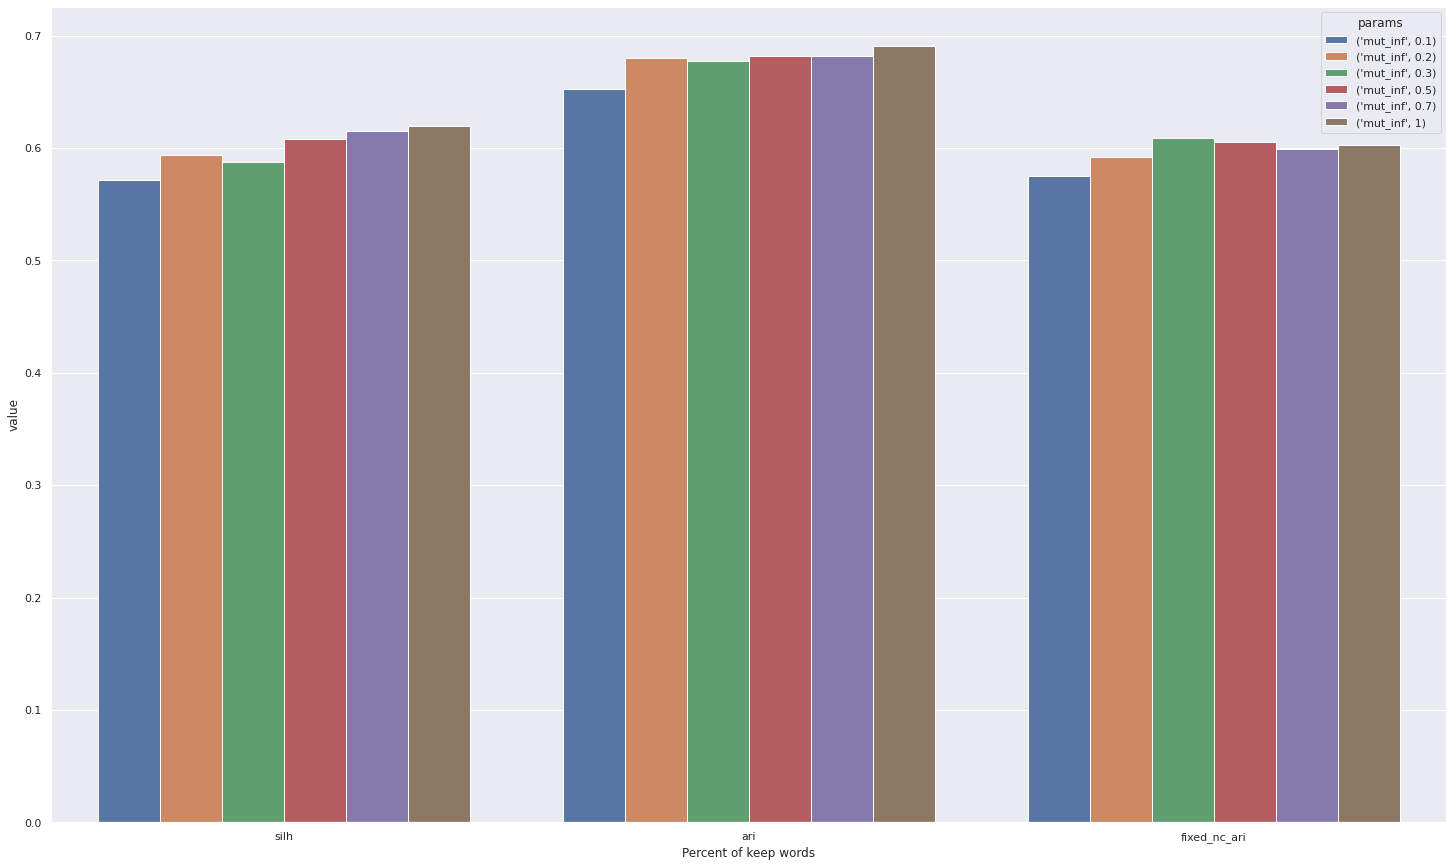

In [112]:
sns.set(rc={'figure.figsize':(25,15)})

feat_mutinf_df = pd.DataFrame(feat_imp_mutinf_metrics[1])#.sort_values(['value']).reset_index(drop=False)
tmp = sns.barplot(data=feat_mutinf_df, x='metric', y='value', hue='params').set(xlabel='Percent of keep words')


In [123]:
mut_inf_check_vec_conf = {
    'vec_mode': ['count'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150],
    'ood_prob': [1e-7],
    'min_df': [3],
    'feature_select_mode': ['mut_inf'],
    'keep_imp_proc': [1],
    'debug':[True],
}

In [124]:
feat_imp_mutinf_check_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    mut_inf_check_vec_conf, 
    default_clustering_conf,
    searching_params = ['feature_select_mode', 'keep_imp_proc']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 2.4430735111236572 sec.
VECTORIZER TRANSFORM STARTED: 
FEATURE SELECTION makes brrrr
Text 0: [0 0 0 ... 0 0 0] Total words: 144
Label0
Text 1: [0 0 0 ... 0 0 0] Total words: 145
Label0
Text 2: [0 0 0 ... 0 0 0] Total words: 144
Label0
20 most useless words: 
             word  importance_score
0        заставка          0.001765
1        закладка          0.001769
2      шестьдесят          0.001773
3        интернат          0.001777
4   тренироваться          0.001777
5         условно          0.001779
6         орослый          0.001779
7       присвоить          0.001783
8         строить          0.001783
9         снижать          0.001783
10      создавать          0.001783
11     притязание          0.001785
12        венгрия          0.001785
13           русь          0.001787
14           2007          0.001787
15        таганка          0.001787
16     телестуд

### Параметры sklearn.Vectorizer

In [82]:
tfidf_vec_conf = {
    'vec_mode': ['count', 'tfidf'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150],
    'ood_prob': [1e-7],
    'min_df': [1, 3, 5, 10],
#     'feature_select_mode': ['mut_inf'],
#     'keep_imp_proc': [0.1, 0.2, 0.3, 0.5, 0.7, 1]
    
}

In [83]:
tfidf_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    tfidf_vec_conf, 
    default_clustering_conf,
    searching_params = ['vec_mode', 'min_df']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 3.665130615234375 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.72696304321289 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 13.088620662689209 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.256655931472778 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.399715662002563 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.241227388381958 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 13.846750259399414 sec.
COMPUTING LABELS STARTED


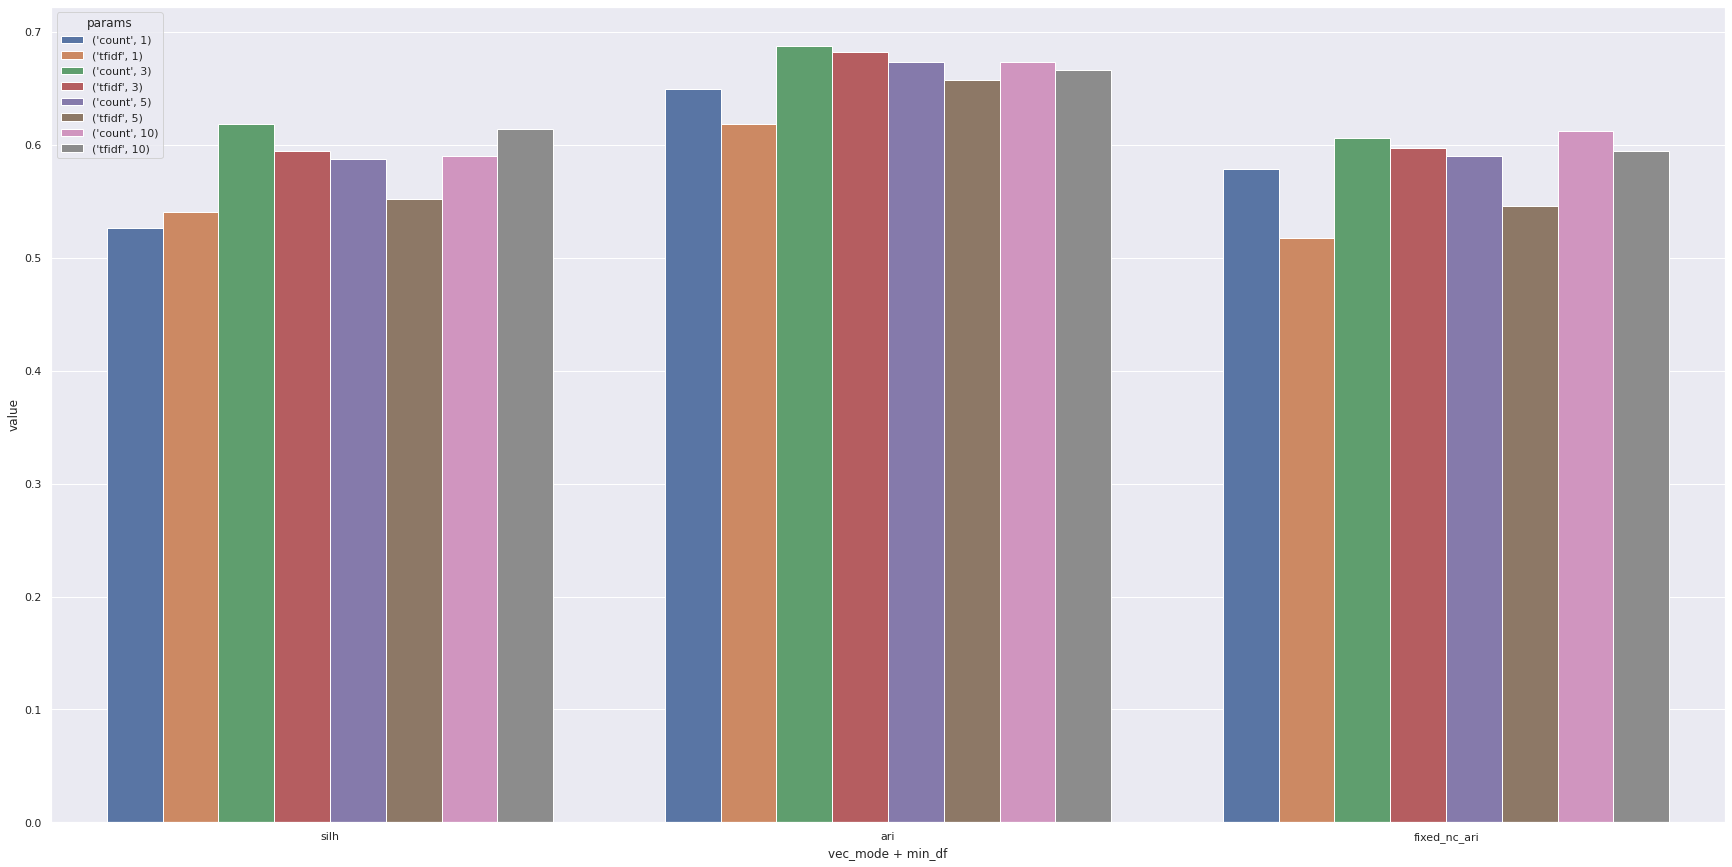

In [115]:
sns.set(rc={'figure.figsize':(30,15)})

tfidf_df = pd.DataFrame(tfidf_metrics[1])#.sort_values(['value']).reset_index(drop=False)
tmp = sns.barplot(data=tfidf_df, x='metric', y='value', hue='params').set(xlabel='vec_mode + min_df')


In [85]:
mindf_search_vec_conf = {
    'vec_mode': ['count', 'tfidf'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150],
    'ood_prob': [1e-7],
    'min_df': [2, 3, 4, 5],    
}

In [86]:
mindf_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    mindf_search_vec_conf, 
    default_clustering_conf,
    searching_params = ['vec_mode', 'min_df']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 4.816244602203369 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 15.103881597518921 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 13.316386938095093 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.970581293106079 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.643773317337036 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.885742425918579 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.842961072921753 sec.
COMPUTING LABELS STARTED

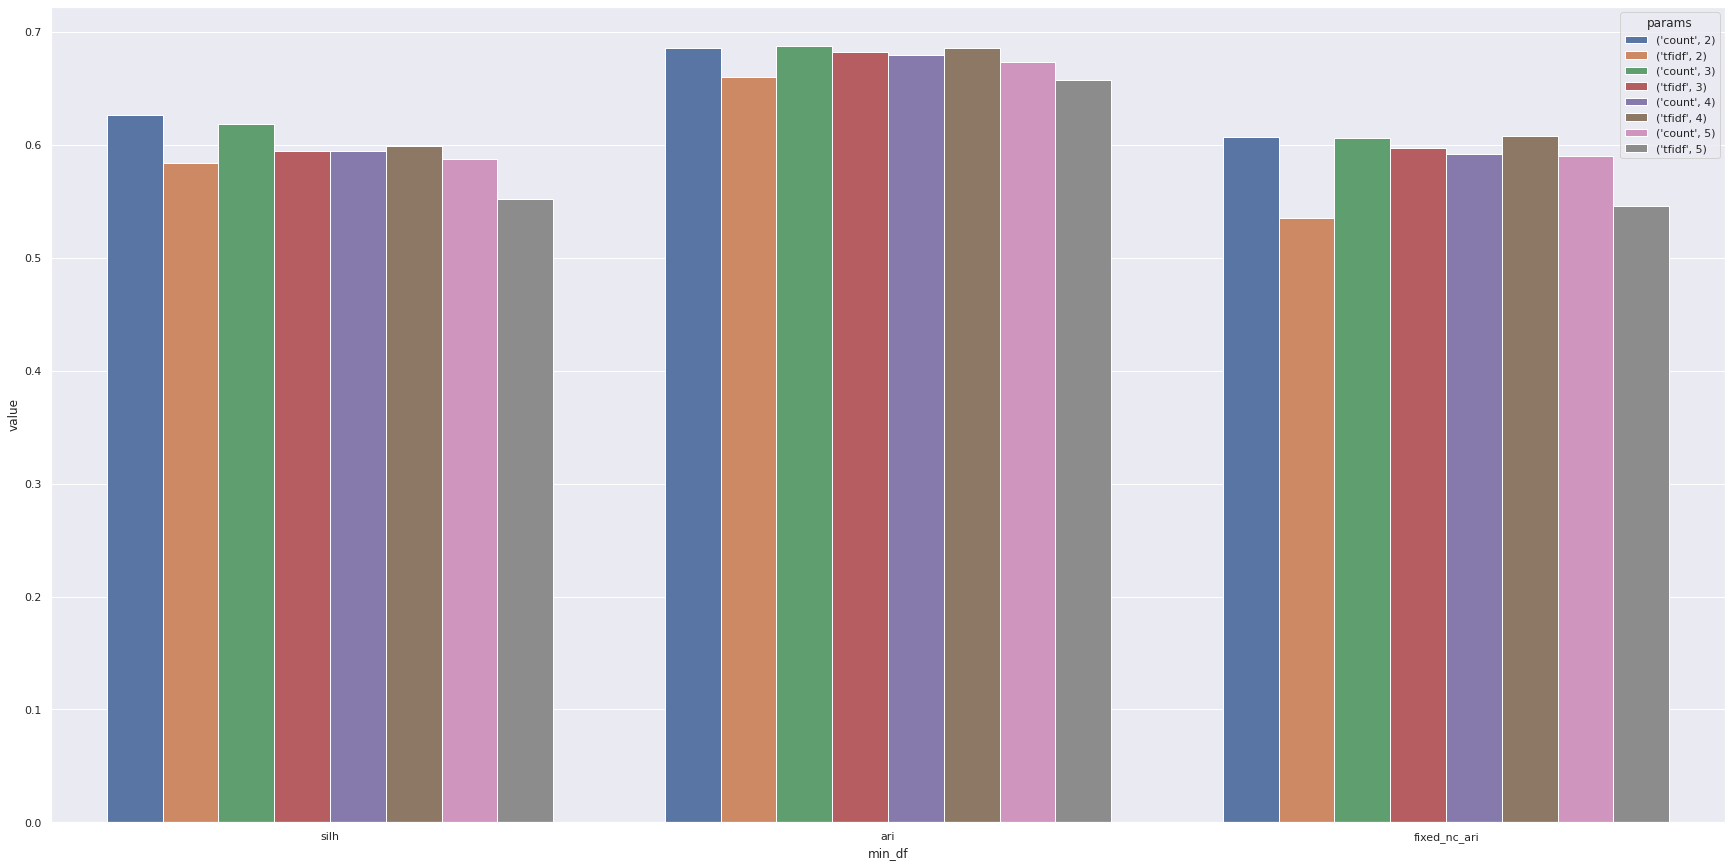

In [117]:
sns.set(rc={'figure.figsize':(30,15)})

mindf_df = pd.DataFrame(mindf_metrics[1])#.sort_values(['value']).reset_index(drop=False)
tmp = sns.barplot(data=mindf_df, x='metric', y='value', hue='params').set(xlabel='min_df')


In [88]:
ood_prob_vec_conf = {
    'vec_mode': ['count'],
    'comb_mode': ['mean'],
    'ood_mode': ['eps'],
    'top_k': [150, 100, 75],
    'ood_prob': [1e-7, 1e-5, 1e-3],
    'min_df': [2],
#     'feature_select_mode': ['mut_inf'],
#     'keep_imp_proc': [0.1, 0.2, 0.3, 0.5, 0.7, 1]
    
}

In [89]:
ood_prob_metrics = grid_search(
    default_wsi_conf, 
    default_lemma_conf, 
    ood_prob_vec_conf, 
    default_clustering_conf,
    searching_params = ['top_k', 'ood_prob']
)

./subst_train/active_subst ('mmm(T)-lemmatized-simple.pkl', 'T(mmm)-lemmatized-simple.pkl')
Lemmatize finished in 3.8466298580169678 sec.
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.874176025390625 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.600497245788574 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.205132007598877 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 11.947717428207397 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 11.917627573013306 sec.
COMPUTING LABELS STARTED
COMPUTING LABELS FINISHING
--------------------
VECTORIZER TRANSFORM STARTED: 
Vectorizing finished in 12.43311619758606 sec.
COMPUTING LABELS STARTED

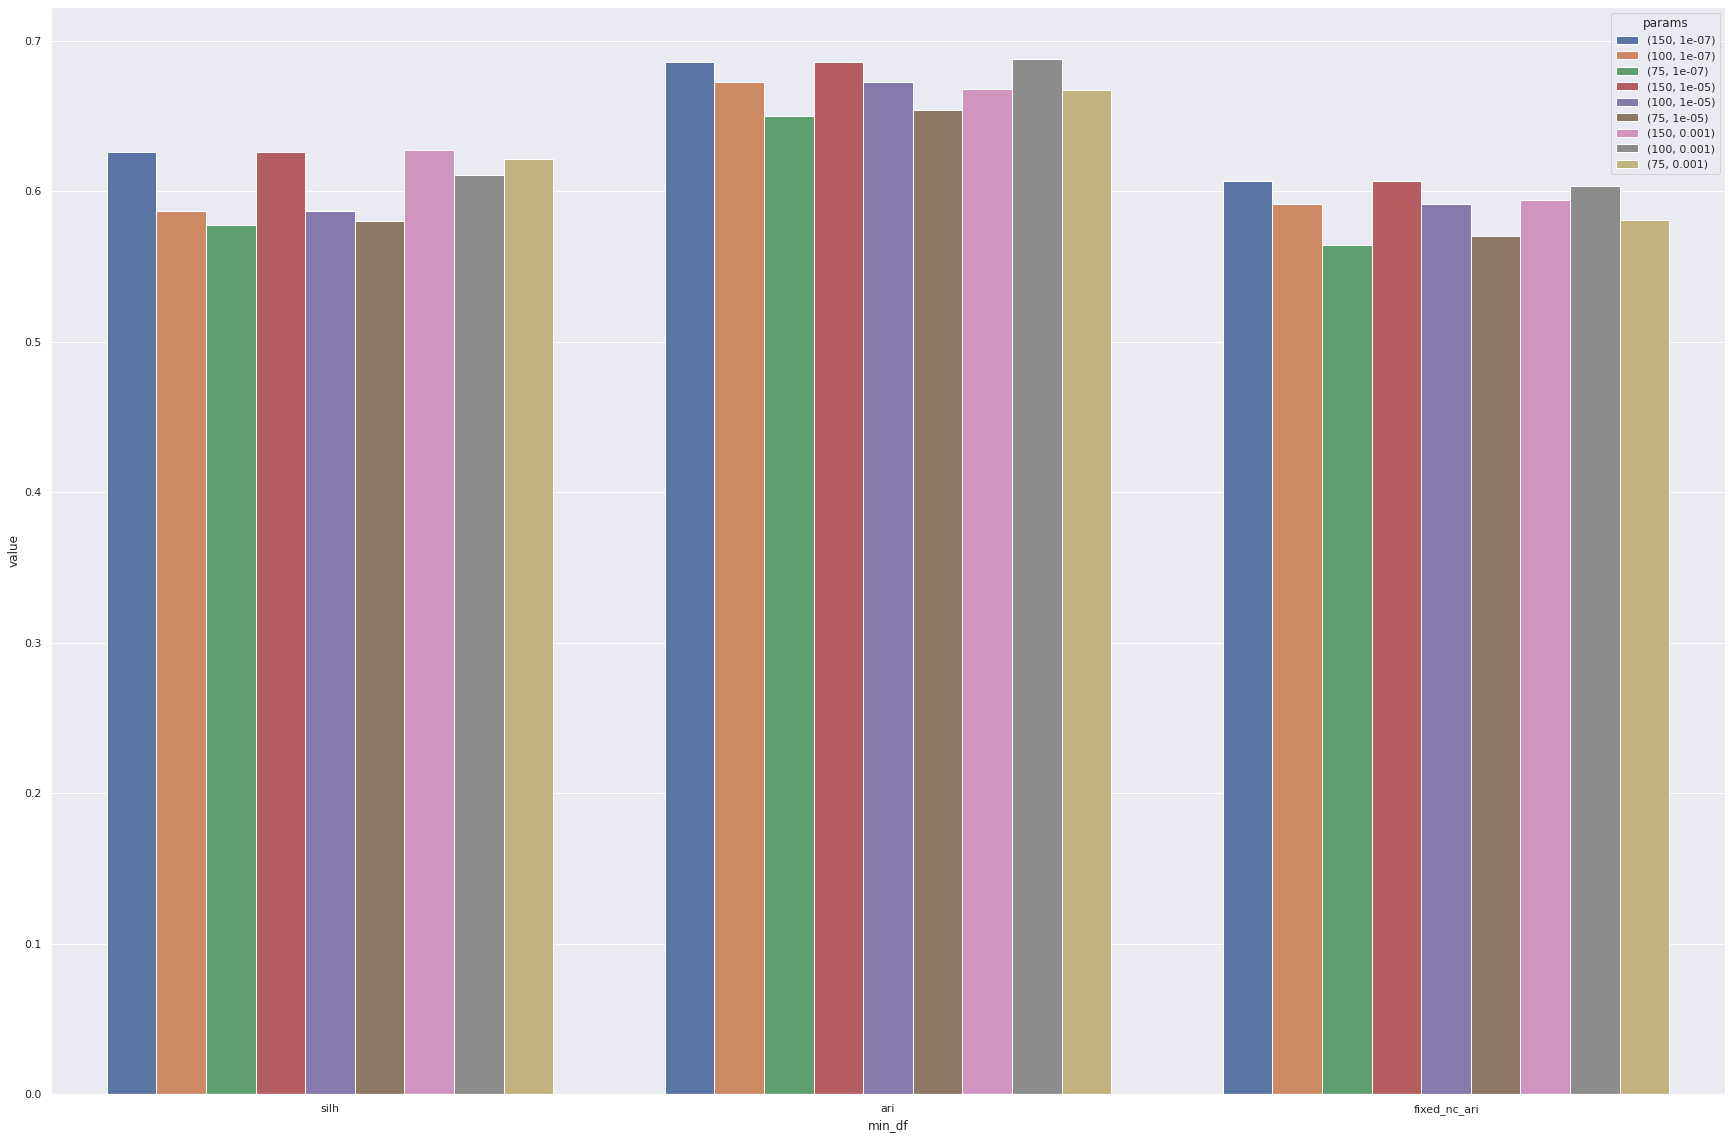

In [119]:
sns.set(rc={'figure.figsize':(30,20)})
ood_prob_df = pd.DataFrame(ood_prob_metrics[1])#.sort_values(['value']).reset_index(drop=False)
tmp = sns.barplot(data=ood_prob_df, x='metric', y='value', hue='params').set(xlabel='min_df')


In [91]:
ood_prob_metrics[0]

[((150, 1e-07),
  {'silh': 0.6259442993318882,
   'ari': 0.685766877909306,
   'fixed_nc_ari': (3, 0.6065581612407837)}),
 ((100, 1e-07),
  {'silh': 0.5865844227252505,
   'ari': 0.6724533084223668,
   'fixed_nc_ari': (4, 0.5914485044395621)}),
 ((75, 1e-07),
  {'silh': 0.5778299470515348,
   'ari': 0.6498654976898457,
   'fixed_nc_ari': (3, 0.5639909685128782)}),
 ((150, 1e-05),
  {'silh': 0.6259442993318882,
   'ari': 0.685766877909306,
   'fixed_nc_ari': (3, 0.6065581612407837)}),
 ((100, 1e-05),
  {'silh': 0.5865844227252505,
   'ari': 0.6724533084223668,
   'fixed_nc_ari': (4, 0.5914485044395621)}),
 ((75, 1e-05),
  {'silh': 0.5800171729098519,
   'ari': 0.6542047225851313,
   'fixed_nc_ari': (4, 0.5700807951148807)}),
 ((150, 0.001),
  {'silh': 0.6273365274676939,
   'ari': 0.6678200796204125,
   'fixed_nc_ari': (3, 0.5943734783611796)}),
 ((100, 0.001),
  {'silh': 0.6108309138818163,
   'ari': 0.6878376985634921,
   'fixed_nc_ari': (3, 0.6036815963059349)}),
 ((75, 0.001),
  {'s